In [1]:
using Pkg
# Pkg.update()
Pkg.instantiate()

using DevCommunities
using SimpleHypergraphs
using StatsBase
using Plots, LinearAlgebra
using DelimitedFiles
using Distances
using Graphs

┌ Warning: The plotting functionality of HyperNetX will not work!
│ Conda Python HyperNetX not found.
│ To test your installation try running `using PyCall;pyimport("networkx");pyimport("hypernetx")`
└ @ SimpleHypergraphs /Users/ddevin/.julia/packages/SimpleHypergraphs/lfXYf/src/SimpleHypergraphs.jl:62


In [2]:
# g = build_hg("../../hgs/apl.hg")
# num_nodes = nhv(g[1])
# num_edges = nhe(g[1])
# println("Number of nodes: $num_nodes")
# println("Number of edges: $num_edges")

my_tags_so = ["rust" ,"elixir","clojure", "typescript" ,"julia", "python", "delphi", "go" ,"sql", "c#" ,"kotlin", "swift" ,"dart" ,"html", "solidity", "javascript", "f#", "bash" ,"lisp", "apl"]
# order by lexigraphical order
my_tags_so = sort(my_tags_so)

20-element Vector{String}:
 "apl"
 "bash"
 "c#"
 "clojure"
 "dart"
 "delphi"
 "elixir"
 "f#"
 "go"
 "html"
 "javascript"
 "julia"
 "kotlin"
 "lisp"
 "python"
 "rust"
 "solidity"
 "sql"
 "swift"
 "typescript"

In [7]:
function build_hg_randoms(path)

    nodes = Dict{Int,Int}()
    degree_nodes = Dict{Int,Int}()
    nodes_per_edge = Dict{Int,Vector{Int}}()

    print(nodes)
    hg = Hypergraph(0,0)
    for line in eachline(path)
        # split elemnts of the line by comma
        d = split(line, ",")
        vs = map(x -> parse(Int,(strip(replace(x, r"\[|\]" => "")))), d)
        for v in vs
            if !haskey(nodes, v)
                v_id = SimpleHypergraphs.add_vertex!(hg)
                push!(nodes, v=>v_id)
            end
        end
        # add he 
        vertices = Dict{Int, Bool}(nodes[v] => true for v in vs)

        # count degree of each node
        for v in vs
            if !haskey(degree_nodes, v)
                degree_nodes[v] = 0
            end
            degree_nodes[v] += 1
        end
        
        he_id = SimpleHypergraphs.add_hyperedge!(hg; vertices = vertices)
        push!(nodes_per_edge, he_id => vs)  
    end

    sum_degree_nodes = sum(values(degree_nodes))
    sum_degree_edges = sum(values(length(nodes_per_edge)))

    function prob_nodes(v)
        return degree_nodes[v]/sum_degree_nodes
    end

    function prob_edges(e)
        return length(nodes_per_edge[e])/sum_degree_edges
    end

    random_nodes_probs = Dict{Int,Float64}()
    random_edges_probs = Dict{Int,Float64}()

    for key in keys(nodes)
        pr = prob_nodes(key)
        random_nodes_probs[key] = pr
    end

    for key in keys(nodes_per_edge)
        pr = prob_edges(key)
        random_edges_probs[key] = pr
    end

    random_nodes = Dict{Int,Int}()
    random_nodes_per_edge = Dict{Int,Vector{Int}}()

    random_hg = Hypergraph(0,0)

    rnp = collect(keys(sort(random_nodes_probs)))
    rnp_weights = pweights(ProbabilityWeights(collect(values(sort(random_nodes_probs)))))
    rep = collect(keys(sort(random_edges_probs)))
    rep_weights = pweights(ProbabilityWeights(collect(values(sort(random_edges_probs)))))

    for i in 1:sum_degree_nodes
        v = sample(rnp, rnp_weights)
        e = sample(rep, rep_weights)

        if !haskey(random_nodes, v)
            v_id = SimpleHypergraphs.add_vertex!(random_hg)
            push!(random_nodes, v=>v_id)
        end

        if !haskey(random_nodes_per_edge, e)
            random_nodes_per_edge[e] = []
        end
        random_nodes_per_edge[e] = push!(random_nodes_per_edge[e], v)        
    end

    for key in keys(random_nodes_per_edge)
        vertices = Dict{Int, Bool}(random_nodes[v] => true for v in random_nodes_per_edge[key])
        he_id = SimpleHypergraphs.add_hyperedge!(random_hg; vertices = vertices)
    end

    return random_hg
end

build_hg_randoms (generic function with 1 method)

In [ ]:

rg = build_hg_randoms("../../hgs/apl.hg")
hg_save("../../randoms/randomPIPE", rg)

# open file
r1 = open("../../randoms/randomPIPE")
# substitue in each line "=true" with ","
run(`sed -i '' 's/=true/,/g' ../../randoms/randomPIPE`)
# remove first line
run(`sed -i '' '1d' ../../randoms/randomPIPE`)
# hash and rewriting id
run(`python3 rewrite.py ../../randoms/randomPIPE 1`)

run(`bash orb.sh`)


# println(nhv(random_hg))
# println(nhe(random_hg))
# hg_save("../../randoms/realRandom", random_hg)


In [ ]:
 # open file
 r1 = open("../../randoms/realRandom")
 # substitue in each line "=true" with ","
 run(`sed -i '' 's/=true/,/g' ../../randoms/realRandom`)
 # remove first line
 run(`sed -i '' '1d' ../../randoms/realRandom`)
 # hash and rewriting id
 run(`python3 rewrite.py ../../randoms/realRandom 1`)
 close(r1)

In [8]:
all_arrays = []
for i in 1:20
    # g = build_hg("../../hgs/apl.hg")
    
    println("building hg for tag: "*my_tags_so[i])
    g = build_hg("../../hgs/"*my_tags_so[i]*".hg")

    num_nodes = nhv(g[1])
    num_edges = nhe(g[1])
    println("Number of nodes: $num_nodes")
    println("Number of edges: $num_edges")
    flush(stdout)

    total_random_motif_count = [0 for i in 1:26]
    # generate 5 model and do average counting
    for j in range(1,5)
        rm_pa = build_hg_randoms("../../hgsFilter/"*my_tags_so[i]*".hg")
        hg_save("../../randoms/randomPIPE", rm_pa)
        
        # open file
        r1 = open("../../randoms/randomPIPE")
        # substitue in each line "=true" with ","
        run(`sed -i '' 's/=true/,/g' ../../randoms/randomPIPE`)
        # remove first line
        run(`sed -i '' '1d' ../../randoms/randomPIPE`)
        # hash and rewriting id
        run(`python3 rewrite.py ../../randoms/randomPIPE 1`)
        
        run(`bash orb.sh`)
        
        # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/randoms/randomPIPE.hg"`)
        # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/hgs/apl.hg"`)
        close(r1)
        r2 = open("/Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt")
        array = []
        for line in eachline(r2)
            if occursin("motif", line)
                if occursin("counting", line)
                    continue
                end
                # find integers in line after ":"
                motif = parse.(Int64, split(line, ":")[2:end])
                push!(array, motif[1])
            end
        end
        # array of any to array of integers
        array = convert(Array{Int64}, array)
        total_random_motif_count = [x + y for (x, y) in zip(array, total_random_motif_count)]
        close(r2)
        println("done with random model "*string(j))
        flush(stdout)
        # flush
    end

    total_random_motif_count = [x / 5 for x in total_random_motif_count]
    total_random_motif_count = ceil.(Int64, total_random_motif_count)
    println(total_random_motif_count)
    push!(all_arrays, total_random_motif_count)
end

println(all_arrays)
# write to file
open("/Users/ddevin/Documents/vscode/DevCommunities/results/all_motifs_countedFilter.csv", "w") do io
    for i in 1:20
        # write(io, string(my_tags_so[i]))
        # write(io, ",")
        for j in 1:26
            if length(all_arrays[i]) == 0
                write(io, string(0))
                write(io, ",")
            else
                write(io, string(all_arrays[i][j]))
                write(io, ",")
            end
        end
        write(io, "\n")
    end
end





building hg for tag: apl


Number of nodes: 1341
Number of edges: 1136


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[148, 551, 1, 8, 5, 101, 0, 0, 0, 0, 1, 6, 0, 0, 0, 1, 0, 0, 12, 103, 89, 1325, 0, 0, 4, 21]
building hg for tag: bash
Number of nodes: 18484


Number of edges: 17540


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[1199625, 9627480, 3363, 30410, 88399, 972760, 0, 48, 119, 2384, 1413, 33177, 0, 3, 50, 390, 0, 0, 78402, 1322375, 1176844, 29847815, 0, 784, 24816, 286990]
building hg for tag: c#
Number of nodes: 81360


Number of edges: 102199


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[19917626, 107177552, 8592, 74787, 151474, 1417841, 0, 6, 21, 576, 272, 5559, 0, 0, 0, 7, 0, 0, 135623, 2298654, 1995732, 38720100, 0, 140, 4973, 46733]
building hg for tag: clojure
Number of nodes: 694
Number of edges: 915


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[13456, 68160, 230, 1349, 4375, 23957, 2, 11, 35, 389, 187, 2524, 0, 1, 23, 83, 0, 0, 569, 6041, 6647, 96651, 0, 21, 542, 3348]
building hg for tag: dart
Number of nodes: 23448


Number of edges: 32499


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[5126813, 31198263, 3423, 28407, 62527, 520939, 0, 11, 20, 313, 53, 2910, 0, 0, 2, 4, 0, 0, 22042, 409821, 356517, 7673487, 0, 27, 1114, 11663]
building hg for tag: delphi
Number of nodes: 1803
Number of edges: 2673


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[25669, 91263, 424, 1394, 4304, 15356, 1, 12, 19, 219, 58, 921, 0, 1, 3, 22, 0, 0, 839, 7316, 8052, 79383, 0, 17, 285, 1230]
building hg for tag: elixir
Number of nodes: 810
Number of edges: 972


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[7545, 22504, 236, 678, 1693, 6441, 0, 10, 11, 115, 54, 531, 0, 0, 5, 15, 0, 0, 264, 2103, 2027, 19893, 0, 7, 108, 450]
building hg for tag: f#
Number of nodes: 822
Number of edges: 1347


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[9051, 37711, 116, 849, 1688, 11069, 1, 4, 8, 138, 52, 903, 0, 0, 5, 20, 0, 0, 447, 5410, 4847, 70614, 0, 15, 274, 1830]
building hg for tag: go
Number of nodes: 78704


Number of edges: 76050


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[2497285, 15569052, 597, 5893, 13280, 128102, 0, 0, 0, 28, 5, 389, 0, 0, 0, 0, 0, 0, 15364, 258269, 262544, 4929577, 0, 14, 524, 3812]
building hg for tag: html
Number of nodes: 122961


Number of edges: 113988


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[8566681, 57709760, 1391, 14343, 29428, 304338, 0, 0, 12, 47, 18, 634, 0, 0, 0, 0, 0, 0, 48132, 1029375, 942816, 21794350, 0, 18, 971, 9458]
building hg for tag: javascript
Number of nodes: 227390


Number of edges: 279061


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[107586792, 791651595, 15432, 187267, 379615, 4833484, 0, 0, 0, 554, 522, 9211, 0, 0, 0, 0, 0, 0, 664668, 13474274, 13487889, 303557858, 0, 449, 14875, 167042]
building hg for tag: julia
Number of nodes: 1945
Number of edges: 3214


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[147783, 459117, 1478, 9586, 15681, 105465, 1, 27, 50, 747, 466, 5496, 0, 3, 27, 86, 0, 0, 3865, 49969, 34021, 523612, 0, 64, 1283, 8708]
building hg for tag: kotlin
Number of nodes: 22706


Number of edges: 26508


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[2094935, 13682552, 1576, 16551, 32998, 336646, 0, 4, 24, 254, 141, 2926, 0, 0, 0, 5, 0, 0, 10750, 207332, 190264, 3809129, 0, 23, 914, 8915]
building hg for tag: lisp
Number of nodes: 665
Number of edges: 933


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[4337, 26111, 89, 631, 1512, 12173, 1, 7, 9, 202, 93, 1629, 0, 1, 12, 71, 0, 0, 668, 8420, 6713, 120938, 0, 27, 663, 4878]
building hg for tag: python
Number of nodes: 295974


Number of edges: 431319


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[566236657, 3892287291, 103545, 1405288, 2288205, 31143189, 0, 90, 262, 4623, 5231, 86647, 0, 0, 0, 92, 0, 0, 3793867, 78311303, 71767428, 1606458236, 0, 2398, 100071, 1175359]
building hg for tag: rust
Number of nodes: 7957


Number of edges: 10984


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[110919, 546847, 362, 2468, 5600, 42566, 1, 3, 13, 112, 51, 1032, 0, 0, 1, 8, 0, 0, 5053, 61589, 58326, 940002, 0, 38, 897, 6660]
building hg for tag: solidity
Number of nodes: 3403


Number of edges: 3103


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[19979, 76297, 126, 668, 2394, 9801, 0, 2, 4, 42, 24, 197, 0, 0, 1, 2, 0, 0, 198, 2447, 2757, 30595, 0, 2, 30, 209]
building hg for tag: sql
Number of nodes: 139097


Number of edges: 154341


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}(

)

done with random model 5


[3919505710, 21970387528, 3579353, 34072975, 62594517, 568863731, 0, 13711, 22087, 506705, 158688, 4741750, 0, 0, 940, 12808, 0, 0, 7744392, 136455094, 126463722, 2267514284, 0, 19173, 628897, 5577106]
building hg for tag: swift
Number of nodes: 23712


Number of edges: 38870


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[4136922, 19792840, 5692, 44290, 91110, 754075, 0, 7, 88, 830, 765, 9087, 0, 0, 7, 34, 0, 0, 60288, 909848, 782056, 13296725, 0, 219, 6015, 49417]
building hg for tag: typescript
Number of nodes: 51998


Number of edges: 54126


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[2992198, 19197351, 783, 9162, 15752, 186786, 0, 0, 6, 37, 48, 600, 0, 0, 4, 0, 0, 0, 10284, 220453, 183914, 4124953, 0, 4, 292, 3236]
Any

[[148, 551, 1, 8, 5, 101, 0, 0, 0, 0, 1, 6, 0, 0, 0, 1, 0, 0, 12, 103, 89, 1325, 0, 0, 4, 21], [1199625, 9627480, 3363, 30410, 88399, 972760, 0, 48, 119, 2384, 1413, 33177, 0, 3, 50, 390, 0, 0, 78402, 1322375, 1176844, 29847815, 0, 784, 24816, 286990], [19917626, 107177552, 8592, 74787, 151474, 1417841, 0, 6, 21, 576, 272, 5559, 0, 0, 0, 7, 0, 0, 135623, 2298654, 1995732, 38720100, 0, 140, 4973, 46733], [13456, 68160, 230, 1349, 4375, 23957, 2, 11, 35, 389, 187, 2524, 0, 1, 23, 83, 0, 0, 569, 6041, 6647, 96651, 0, 21, 542, 3348], [5126813, 31198263, 3423, 28407, 62527, 520939, 0, 11, 20, 313, 53, 2910, 0, 0, 2, 4, 0, 0, 22042, 409821, 356517, 7673487, 0, 27, 1114, 11663], [25669, 91263, 424, 1394, 4304, 15356, 1, 12, 19, 219, 58, 921, 0, 1, 3, 22, 0, 0, 839, 7316, 8052, 79383, 0, 17, 285, 1230], [7545, 22504, 236, 678, 1693, 6441, 0, 10, 11, 115, 54, 531, 0, 0, 5, 15, 0, 0, 264, 2103, 2027, 19893, 0, 7, 108, 450], [9051, 37711, 116, 849, 1688, 11069, 1, 4, 8, 138, 52, 903, 0, 0, 5, 20,

In [20]:
############## SINGLE RUN ##################

g = build_hg("../../hgs/"*"sql"*".hg")

num_nodes = nhv(g[1])
num_edges = nhe(g[1])
println("Number of nodes: $num_nodes")
println("Number of edges: $num_edges")
flush(stdout)

total_random_motif_count = [0 for i in 1:26]
# generate 5 model and do average counting
for j in range(1,5)
    rm_pa = build_hg_randoms("../../hgs/"*"sql"*".hg")
    hg_save("../../randoms/randomPIPE", rm_pa)
    
    # open file
    r1 = open("../../randoms/randomPIPE")
    # substitue in each line "=true" with ","
    run(`sed -i '' 's/=true/,/g' ../../randoms/randomPIPE`)
    # remove first line
    run(`sed -i '' '1d' ../../randoms/randomPIPE`)
    # hash and rewriting id
    run(`python3 rewrite.py ../../randoms/randomPIPE 1`)
    
    run(`bash orb.sh`)
    
    # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/randoms/randomPIPE.hg"`)
    # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/hgs/apl.hg"`)
    close(r1)
    r2 = open("/Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt")
    array = []
    for line in eachline(r2)
        if occursin("motif", line)
            if occursin("counting", line)
                continue
            end
            # find integers in line after ":"
            motif = parse.(Int64, split(line, ":")[2:end])
            push!(array, motif[1])
        end
    end
    # array of any to array of integers
    array = convert(Array{Int64}, array)
    total_random_motif_count = [x + y for (x, y) in zip(array, total_random_motif_count)]
    close(r2)
    println("done with random model "*string(j))
    println(total_random_motif_count)
    flush(stdout)
    # flush
end

total_random_motif_count = [x / 5 for x in total_random_motif_count]
total_random_motif_count = ceil.(Int64, total_random_motif_count)
println(total_random_motif_count)
# push!(all_arrays, total_random_motif_count)

Number of nodes: 139097
Number of edges: 154341


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1755 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 1
Int64[]


Dict{Int64, Int64}()

done with random model 2
Int64[]


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1767 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 3
Int64[]


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1779 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 4
Int64[]


Dict{Int64, Int64}()

done with random model 5
Int64[]


Int64[]


run_approx_ver2_par.sh: line 2:  1791 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt
run_approx_ver2_par.sh: line 2:  1803 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


In [22]:
# num_motifs = [1077,818707,23,7,5702,6152,25,1,131,27,10,4,0,0,0,0,5,1,8390,1397,41097,124693,9,582,145,53]
# num_motifs = [2070, 11469, 44796591, 58275821, 16910646, 34130003, 16, 93583226, 404737, 293960662, 70840, 175279493, 1, 4172338, 55998189, 362027234, 0, 0, 31323, 12423927, 14751, 27466910, 0, 152556, 716568, 7659269]

function cps(motifs, motifs_random)
    eps = 1 #fixed in the paper
    deltas = []
    sum_deltas = 0
    for i in 1:length(motifs)
        t = (motifs[i]-motifs_random[i])/(motifs[i]+motifs_random[i]+eps)
        push!(deltas, t)
        sum_deltas += t^2
    end
    cp = []
    for i in 1:length(motifs)
        push!(cp, deltas[i]/sqrt(sum_deltas))
    end
    return cp
end

# cp = cps(num_motifs, motifs_random)
# println(cp)

cps (generic function with 1 method)

In [ ]:
using CSV, DataFrames
data = CSV.read("../../hgs/motifs.csv", DataFrame, header=false)
# for each column create an array of the values
w = open("../../results/cpprofilesAPL.csv", "w")

for i in 1:size(data, 2)
    col = data[:, i]
    col = convert(Array{Int64, 1}, col)
    cp = cps(col, num_motifs)
    new_line = join(cp, ",")
    
    write(w, new_line * "\n")
end
close(w)



In [23]:
using CSV, DataFrames
# data = CSV.read("../../hgs/motifs.csv", DataFrame, header=false)
data = CSV.read("../../results/all_motifs_countedFilter.csv", DataFrame, header=false)
dataRandom = CSV.read("../../results/all_motifs_countedFilterRandoms.csv", DataFrame, header=false)
# for each column create an array of the values
w = open("../../results/cpprofilesALLFilter.csv", "w")
# println(data)
# println(dataRandom)
# match column of data with column of dataRandom

for i in 1:size(data, 1)
    # col = data[:, i]
    col = data[i, :]
    # convert DataFrame row to array
    # col = convert(Array{Int64, 1}, col)
    random_motif = dataRandom[i, :]
    # random_motif = convert(Array{Int64, 1}, random_motif)
    # println(col)
    # println(random_motif)
    cp = cps(col, random_motif)
    new_line = join(cp, ",")
    write(w, new_line * "\n")
end

close(w)



Any[1.0000000000000002 0.40854652806480873 0.6220808426027589 0.4352355491501826 0.5212567357598245 0.5905727295349528 0.5327066772841692 0.42742304212050436 0.19554969628331081 0.4499046144732704 0.3781884622124307 0.6191804527662881 0.5092949431502853 0.48760085650941487 0.3254934133642569 0.643336145051236 0.7645921874057947 0.5305459698668479 0.5607017432128667 0.6479471723312266; 0.40854652806480873 1.0000000000000002 0.6924940332879267 0.7375240498185702 0.6416104773525618 0.699192584171172 0.8148644108613605 0.46297493035152415 0.31488282833399134 0.8404186325252005 0.6567038674706506 0.6915794972001229 0.6602956314105864 0.5692781889387826 0.7570898013809442 0.712523341409516 0.669670311418089 0.9045034093222482 0.55131392414824 0.5669529949446551; 0.6220808426027589 0.6924940332879267 1.0000000000000002 0.6683816242786539 0.947396295391833 0.849738721705861 0.8073161133978161 0.7987757623111184 0.35445400429606294 0.7714916420333064 0.8350188026056984 0.9224372283916696 0.9133

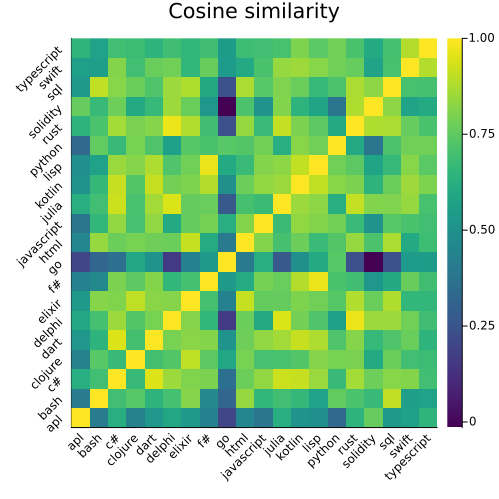

In [28]:
# using LinearAlgebra
# read matrix from csv file
m = readdlm("../../results/cpprofilesALLFilter.csv", ',', Float64)
# mm = pairwise(CosineDist(), m')
# matrix 20x20 of Float64
mm = []

########## COS similarity ##########
for row1 in eachrow(m)
    # mm_row = []
    for row2 in eachrow(m)
        dot = row1'row2
        normalization1 = norm(row1)
        normalization2 = norm(row2)
        cos_sim = dot/(normalization1*normalization2)
        push!(mm, cos_sim)
    end
    # push!(mm, mm_row)
end
# convert mm to a format readable for Plots heatmap
mm = reshape(mm, 20, 20)
println(mm)
######################################
# save matrix to csv file
open("../../results/cpprofilesALLFilter_cos.csv", "w") do io
    for i in 1:20
        for j in 1:20
            write(io, string(mm[i,j]))
            if j != 20
                write(io, ",")
            end
            # write(io, ",")
        end
        write(io, "\n")
    end
end

h = heatmap(mm, color=:viridis, title="Cosine similarity", xticks=([i for i in 1:20], my_tags_so), yticks=([i for i in 1:20], my_tags_so), xrotation=45, yrotation=45, size=(500,500))

In [ ]:
# GENERAL PURPOSE
m = readdlm("../../results/cpprofilesALL.csv", ',', Float64)
general = [3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 19, 20]
# specific = [1, 2, 8, 14, 17, 18]
# matrix 20x20 of Float64
mm = []

m2 = m[general, :]
println(m2)
# ########## COS similarity ##########
for row1 in eachrow(m2)
    # mm_row = []
    for row2 in eachrow(m2)
        dot = row1'row2
        normalization1 = norm(row1)
        normalization2 = norm(row2)
        cos_sim = dot/(normalization1*normalization2)
        push!(mm, cos_sim)
    end
    # push!(mm, mm_row)
end

# convert mm to a format readable for Plots heatmap
mm = reshape(mm, 14, 14)
# ######################################
my_tags_general = ["rust", "elixir", "clojure", "typescript", "julia", "python", "delphi", "go", "c#", "kotlin", "swift", "dart", "html", "javascript"]
sort!(my_tags_general)
h = heatmap(mm, color=:viridis, title="Cosine similarity", xticks=([i for i in 1:14], my_tags_general), yticks=([i for i in 1:14], my_tags_general), xrotation=45, yrotation=45, size=(500,500))

############## SPECIFIC PURPOSE ##################
m = readdlm("../../results/cpprofilesALL.csv", ',', Float64)
# general = [3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 19, 20]
specific = [1, 2, 8, 14, 17, 18]
# matrix 20x20 of Float64
mm = []

m2 = m[specific, :]
println(m2)
# ########## COS similarity ##########
for row1 in eachrow(m2)
    # mm_row = []
    for row2 in eachrow(m2)
        dot = row1'row2
        normalization1 = norm(row1)
        normalization2 = norm(row2)
        cos_sim = dot/(normalization1*normalization2)
        push!(mm, cos_sim)
    end
    # push!(mm, mm_row)
end

# convert mm to a format readable for Plots heatmap
mm = reshape(mm, 6, 6)
# ######################################
my_tags_specific = ["sql", "solidity", "bash", "lisp", "apl", "f#"]
sort!(my_tags_specific)
h = heatmap(mm, color=:viridis, title="Cosine similarity", xticks=([i for i in 1:6], my_tags_specific), yticks=([i for i in 1:6], my_tags_specific), xrotation=45, yrotation=45, size=(500,500))

building hg for tag: apl


building hg for tag: bash


building hg for tag: c#


building hg for tag: clojure


building hg for tag: dart


building hg for tag: delphi


building hg for tag: elixir


building hg for tag: f#


building hg for tag: go


building hg for tag: html


building hg for tag: javascript


building hg for tag: julia


building hg for tag: kotlin


building hg for tag: lisp


building hg for tag: python


building hg for tag: rust


building hg for tag: solidity


building hg for tag: sql


building hg for tag: swift


building hg for tag: typescript


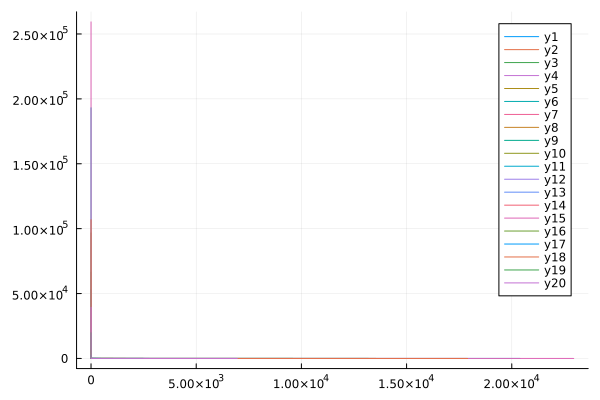

In [115]:
p = Plots.plot()
for i in 1:20
    # g = build_hg("../../hgs/apl.hg")
    
    println("building hg for tag: "*my_tags_so[i])
    g = build_hg("../../hgs/"*my_tags_so[i]*".hg")
    # g = build_hg("../../hgs/"*"apl"*".hg")

    num_nodes = nhv(g[1])
    num_edges = nhe(g[1])
    # println("Number of nodes: $num_nodes")
    # println("Number of edges: $num_edges")
    flush(stdout)

    ccs = SimpleHypergraphs.get_connected_components(g[1])
    ccs = sort(ccs, by=length, rev=true)
    # distribution of component sizes
    ccs_len = length.(ccs)
    
    Plots.plot!(p,ccs_len)
end

p

In [3]:
using Formatting

# p = Plots.plot()

for i in 1:20
    # g = build_hg("../../hgs/apl.hg")
    println("building hg for tag: "*my_tags_so[i])
    g = build_hg("../../hgsFilter/"*my_tags_so[i]*".hg")
    flush(stdout)

    b = BipartiteView(g[1])
    bipartite_graph = Graphs.SimpleGraph(b)

    #compute betweenness centrality of nodes in bipartite graph
    b_centrality = Graphs.betweenness_centrality(bipartite_graph, normalize=true)
    #computer closeness centrality of nodes in bipartite graph
    # c_centrality = Graphs.closeness_centrality(bipartite_graph, normalize=true)
    # #compute degree centrality of nodes in bipartite graph
    # d_centrality = Graphs.degree_centrality(bipartite_graph, normalize=true)
    # #compute eigenvector centrality of nodes in bipartite graph
    # e_centrality = Graphs.eigenvector_centrality(bipartite_graph)
    # save centrality to file
    hg_folder = "../../resultsFilter/centrality/"*my_tags_so[i]*"/"
    # create folder if not exists
    isdir(hg_folder) || mkdir(hg_folder)
    open(hg_folder*"b_centrality"*".csv", "w") do io
        for i in 1:length(b_centrality)
            write(io, format(b_centrality[i]))
            write(io, ",")
        end
    end
    # open(hg_folder*"c_centrality"*".csv", "w") do io
    #     for i in 1:length(c_centrality)
    #         write(io, format(c_centrality[i]))
    #         write(io, ",")
    #     end
    # end
    # open(hg_folder*"d_centrality"*".csv", "w") do io
    #     for i in 1:length(d_centrality)
    #         write(io, format(d_centrality[i]))
    #         write(io, ",")
    #     end
    # end
    # open(hg_folder*"e_centrality"*".csv", "w") do io
    #     for i in 1:length(e_centrality)
    #         write(io, format(e_centrality[i]))
    #         write(io, ",")
    #     end
    # end
    # Plots.plot!(p,centrality,label=my_tags_so[i])
    # Plots.savefig(p, "../../results/centrality/"*my_tags_so[i]*"centrality"*".png")
    flush(stdout)
end

building hg for tag: apl


building hg for tag: bash


building hg for tag: c#


building hg for tag: clojure


building hg for tag: dart


building hg for tag: delphi


building hg for tag: elixir


building hg for tag: f#


building hg for tag: go


building hg for tag: html


building hg for tag: javascript


building hg for tag: julia


building hg for tag: kotlin


building hg for tag: lisp


building hg for tag: python


building hg for tag: rust


building hg for tag: solidity


building hg for tag: sql


building hg for tag: swift


building hg for tag: typescript


In [4]:
dir = "../../hgsFilter/"
all_arrays = []
for file in readdir(dir)
    if endswith(file, ".hg")
        # println(file)
        s = "/Users/ddevin/Documents/vscode/DevCommunities/hgsFilter/"*file
        run(`bash orbGeneral.sh $s`)
        r2 = open("/Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt")
        array = []
        for line in eachline(r2)
            if occursin("motif", line)
                if occursin("counting", line)
                    continue
                end
                # find integers in line after ":"
                motif = parse.(Int64, split(line, ":")[2:end])
                push!(array, motif[1])
            end
        end
        # array of any to array of integers
        array = convert(Array{Int64}, array)
        push!(all_arrays, array)
        close(r2)
    end
end

open("/Users/ddevin/Documents/vscode/DevCommunities/results/all_motifs_countedFilter.csv", "w") do io
    for i in 1:20
        # write(io, string(my_tags_so[i]))
        # write(io, ",")
        for j in 1:26
            if length(all_arrays[i]) == 0
                write(io, string(0))
                write(io, ",")
            else
                write(io, string(all_arrays[i][j]))
                write(io, ",")
            end
        end
        write(io, "\n")
    end
end



Process(`bash orbGeneral.sh /Users/ddevin/Documents/vscode/DevCommunities/hgsFilter/apl.hg`, ProcessExited(0))